# Global Temperature Analysis — Data Scientist Notebook

**Goal:** explore the cleaned climate dataset to identify trends, seasonality, regional differences, and potential anomalies.  
**Outputs:** evidence that can support one or two focused hypotheses for modeling, plus clean figures/tables to hand off to the visualizer.

**Notes**
- Data source: `GlobalTemp_Cleaned_CountryContinent.csv` (country-level only; added `Continent` and `UN_Region` features).
- Grain: monthly per country. I’ll aggregate to year/decade where helpful.
- Approach: start with EDA → narrow to 1–2 hypotheses → choose simple, defensible models (trend tests, decomposition, anomaly baselines).

**EDA plan (incremental)**
1) Sanity checks (shape, time coverage, missingness)  
2) Global annual/decadal trends (moving averages for context)  
3) Seasonality patterns by continent/country  
4) Anomalies vs a baseline (e.g., 1951–1980)  
5) Regional comparisons (slopes by continent)


In [2]:
# Load cleaned dataset and quick overview

import pandas as pd
import numpy as np

# Load cleaned file (dt will parse to datetime)
path = r"C:\Users\Weekseey\Documents\Bellevue Work\Applied Data Science\GlobalTemp_Cleaned_CountryContinent.csv"
df = pd.read_csv(path, parse_dates=["dt"])

# Basic sanity checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Time coverage
print("Date range:", df["dt"].min(), "→", df["dt"].max())

# Unique entities
print("Unique countries:", df["Country"].nunique())
print("Unique continents:", df["Continent"].nunique())
print("Continents:", sorted(df["Continent"].dropna().unique().tolist()))

# Missingness snapshot
miss = (df.isna().mean()*100).round(2).sort_values(ascending=False)
print("\nMissing % by column (top 8):")
print(miss.head(8))

# Peek
df.head(10)

Shape: (518357, 10)
Columns: ['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country', 'Year', 'Month', 'Decade', 'Season', 'Continent', 'UN_Region']
Date range: 1743-11-01 00:00:00 → 2013-09-01 00:00:00
Unique countries: 232
Unique continents: 7
Continents: ['Africa', 'Antarctica', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']

Missing % by column (top 8):
dt                               0.0
AverageTemperature               0.0
AverageTemperatureUncertainty    0.0
Country                          0.0
Year                             0.0
Month                            0.0
Decade                           0.0
Season                           0.0
dtype: float64


,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Year,Month,Decade,Season,Continent,UN_Region
0,1743-11-01,4.384,2.294,Åland,1743,11,1740,Fall,Europe,Northern Europe
1,1744-04-01,1.530,4.680,Åland,1744,4,1740,Spring,Europe,Northern Europe
2,1744-05-01,6.702,1.789,Åland,1744,5,1740,Spring,Europe,Northern Europe
3,1744-06-01,11.609,1.577,Åland,1744,6,1740,Summer,Europe,Northern Europe
4,1744-07-01,15.342,1.410,Åland,1744,7,1740,Summer,Europe,Northern Europe
5,1744-09-01,11.702,1.517,Åland,1744,9,1740,Fall,Europe,Northern Europe
6,1744-10-01,5.477,1.862,Åland,1744,10,1740,Fall,Europe,Northern Europe
7,1744-11-01,3.407,1.425,Åland,1744,11,1740,Fall,Europe,Northern Europe
8,1744-12-01,-2.181,1.641,Åland,1744,12,1740,Winter,Europe,Northern Europe
9,1745-01-01,-3.850,1.841,Åland,1745,1,1740,Winter,Europe,Northern Europe


### Global Annual Trend

Before diving into regions, I want to get a big-picture view of how global temperatures have shifted over time.  
To do this, I’ll average temperatures across all countries by year. This smooths the monthly noise and makes it easier to see long-term changes.  

Key things I’ll look for:  
- Is there a noticeable upward drift in average temperature?  
- Are there distinct “cool” and “warm” periods across the centuries?  
- Does the 20th century stand out compared to earlier data?


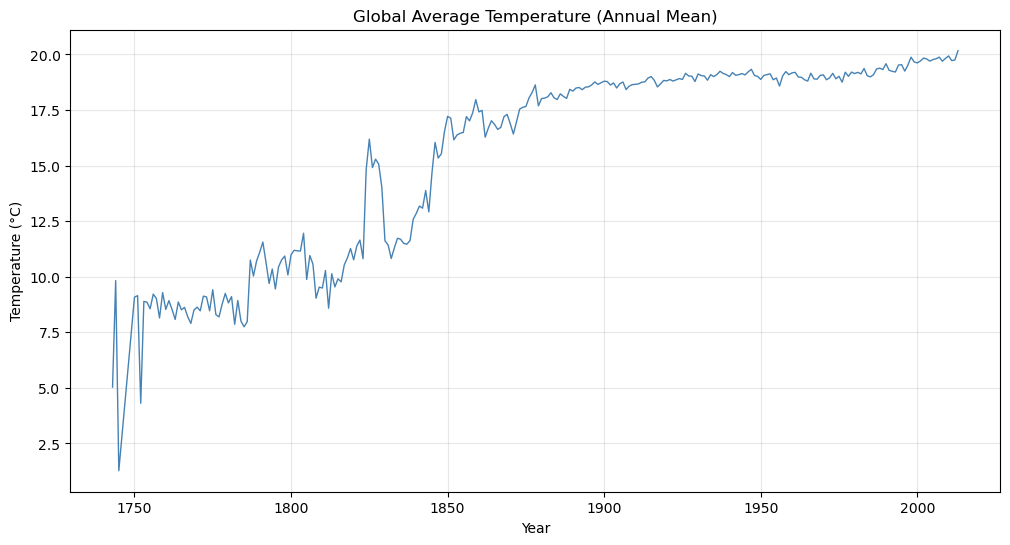

In [4]:
import matplotlib.pyplot as plt

# Aggregate to annual global mean temperature
annual_global = df.groupby("Year")["AverageTemperature"].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(annual_global["Year"], annual_global["AverageTemperature"], color="steelblue", linewidth=1)
plt.title("Global Average Temperature (Annual Mean)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True, alpha=0.3)
plt.show()

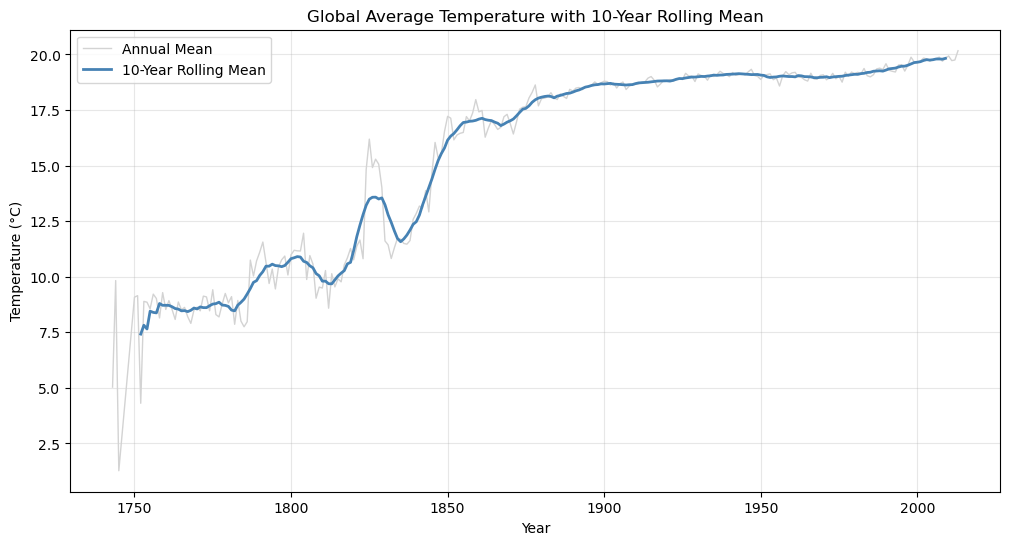

In [5]:
# Add a rolling mean to smooth the trend (10-year window)
annual_global["Rolling10"] = annual_global["AverageTemperature"].rolling(window=10, center=True).mean()

plt.figure(figsize=(12,6))
plt.plot(annual_global["Year"], annual_global["AverageTemperature"], color="lightgray", linewidth=1, label="Annual Mean")
plt.plot(annual_global["Year"], annual_global["Rolling10"], color="steelblue", linewidth=2, label="10-Year Rolling Mean")
plt.title("Global Average Temperature with 10-Year Rolling Mean")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Observations from Rolling Average

The 10-year rolling mean helps smooth out the noise in the early records and highlights the long-term signal:

- The early dataset (pre-1850) shows a lot of variability, including a sharp spike between about 1800 and 1850. This is likely tied to sparse or inconsistent measurements, though it could also reflect real climate anomalies.  
- From around 1850 onward, the rolling mean reveals a steady upward climb in global temperatures.  
- The 20th century shows sustained warming, with the late 1900s to early 2000s pushing global averages to the highest levels in the dataset (~20°C).  
- The long-term signal strongly suggests a persistent global warming trend rather than short-term fluctuation.


---

### Continental Temperature Trends

After looking at the global signal, I want to compare how different continents have experienced temperature changes.  
This will help answer one of our core research questions: *“How have global temperatures changed across regions?”*  

By plotting rolling averages for each continent on the same graph, I can see:  
- Which regions show the strongest long-term warming  
- Whether equatorial regions (e.g., Africa) remain more stable  
- If continental climates (e.g., Europe, Asia) show sharper variability


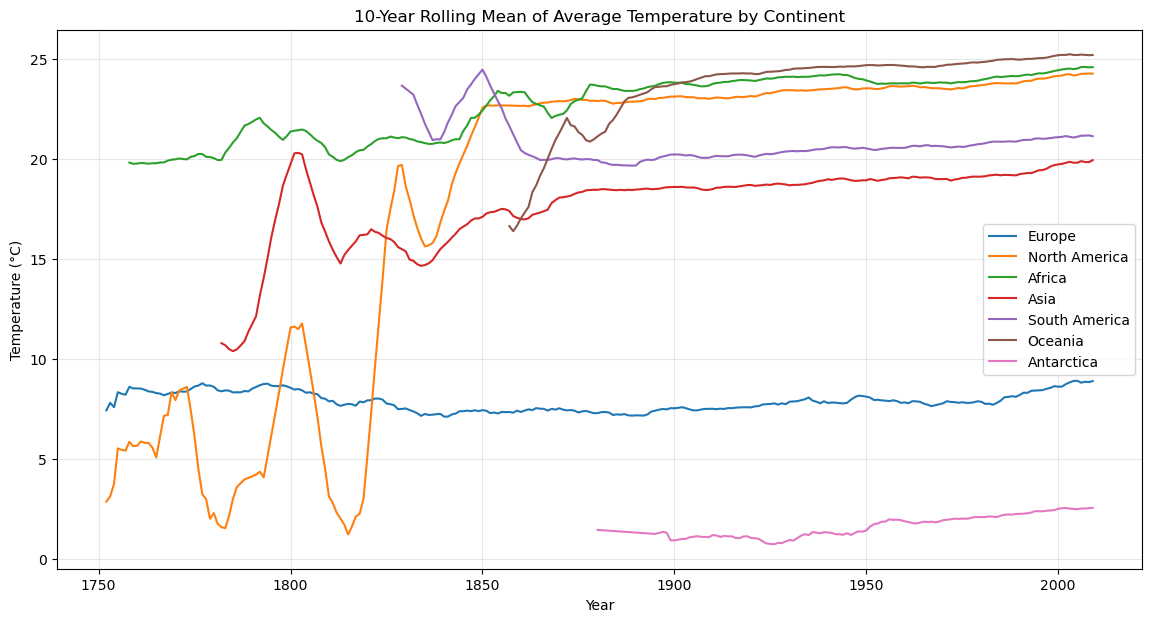

In [9]:
# Aggregate annual means by continent
annual_continent = (
    df.groupby(["Year", "Continent"])["AverageTemperature"]
      .mean()
      .reset_index()
)

# Add rolling mean (10 years) per continent
annual_continent["Rolling10"] = (
    annual_continent.groupby("Continent")["AverageTemperature"]
    .transform(lambda x: x.rolling(10, center=True).mean())
)

# Plot
plt.figure(figsize=(14,7))

for cont in annual_continent["Continent"].unique():
    subset = annual_continent[annual_continent["Continent"] == cont]
    plt.plot(subset["Year"], subset["Rolling10"], label=cont)

plt.title("10-Year Rolling Mean of Average Temperature by Continent")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Observations from Continental Temperature Trends

- **Baseline differences:**  
  Africa, Oceania, and South America consistently sit at the higher end (~20–25°C), while Europe and Antarctica remain the coldest regions.  

- **Stability vs. variability:**  
  Africa shows remarkable stability with relatively minor swings, while North America and Asia display much more volatility in the early records.  

- **Long-term warming:**  
  All continents display a gradual warming trend over the 20th century, with the clearest signals in Oceania, South America, and Asia.  

- **Data quality issues:**  
  The dramatic fluctuations in North America and Asia before ~1850 are suspicious and likely tied to sparse or inconsistent data coverage rather than true climate shifts.  
  This raises the question of whether it might be more useful for analysis to limit the focus to the post-1850 period, where the records appear more consistent and reliable.


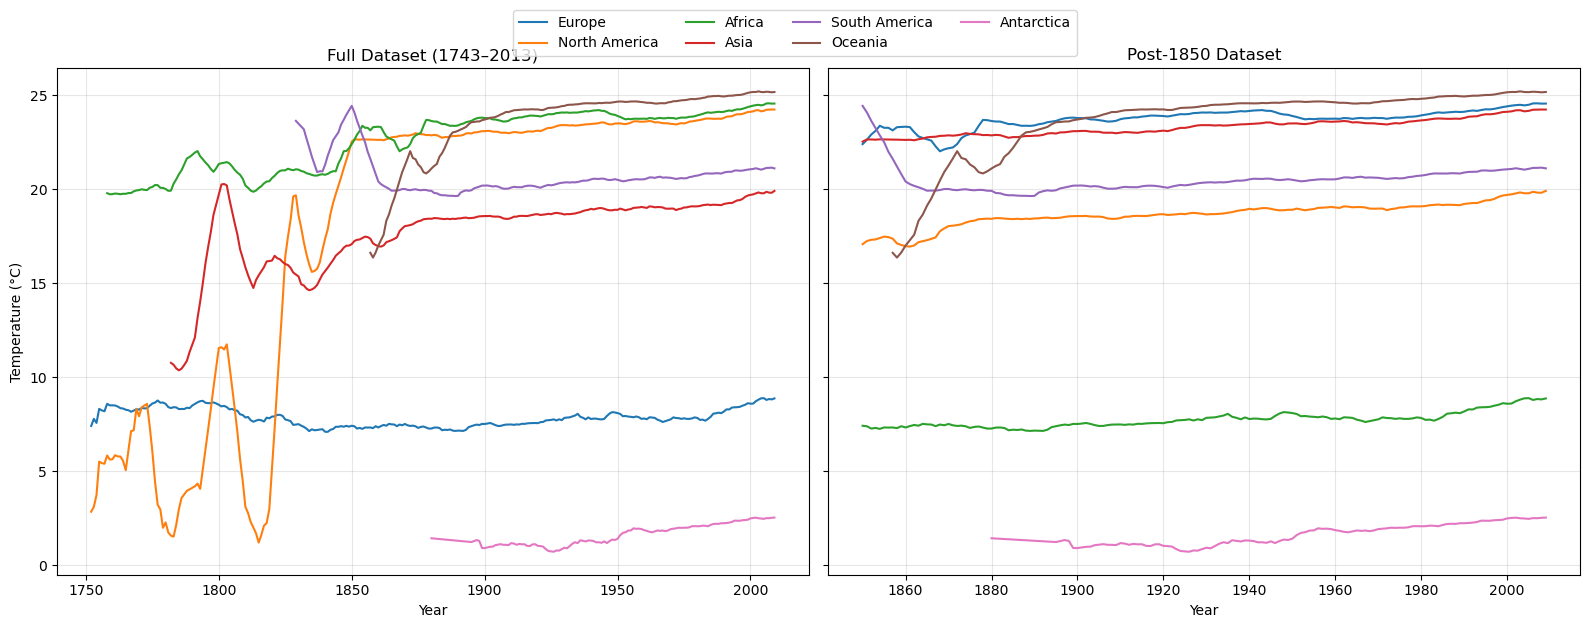

In [11]:
# Compare full dataset vs post-1850 only

# Full dataset (already computed as annual_continent)
full = annual_continent.copy()

# Subset: post-1850
post1850 = annual_continent[annual_continent["Year"] >= 1850]

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# Full dataset
for cont in full["Continent"].unique():
    subset = full[full["Continent"] == cont]
    axes[0].plot(subset["Year"], subset["Rolling10"], label=cont)
axes[0].set_title("Full Dataset (1743–2013)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Temperature (°C)")
axes[0].grid(True, alpha=0.3)

# Post-1850 dataset
for cont in post1850["Continent"].unique():
    subset = post1850[post1850["Continent"] == cont]
    axes[1].plot(subset["Year"], subset["Rolling10"], label=cont)
axes[1].set_title("Post-1850 Dataset")
axes[1].set_xlabel("Year")
axes[1].grid(True, alpha=0.3)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()

### Narrowing Focus to Post-1850 Data

Based on the volatility in the early records and group consensus, I’m going to narrow the dataset to the period after 1850.  
This cutoff reduces the noise from sparse or inconsistent early measurements and lets us focus on the most reliable data for analysis.  
The result should be clearer insights into long-term warming trends and regional comparisons.


In [13]:
# Create a filtered dataset for analysis (post-1850)
df_post1850 = df[df["Year"] >= 1850].copy()

print("Original rows:", df.shape[0])
print("Post-1850 rows:", df_post1850.shape[0])
print("Year range:", df_post1850["Year"].min(), "→", df_post1850["Year"].max())

Original rows: 518357
Post-1850 rows: 432933
Year range: 1850 → 2013


---

### Analysis Scope

For the remainder of the analysis, I’ll be working with the post-1850 dataset.  
This keeps the data more reliable and consistent while still capturing over 160 years of global climate trends.  
Any observations and models will be based on this refined scope.


---

### Seasonal Averages by Continent

To explore how seasonal patterns differ across regions, I’m going to calculate the mean temperature for each continent by season (Winter, Spring, Summer, Fall). This should help highlight whether equatorial regions like Africa and South America remain relatively stable year-round compared to continental regions like Europe and Asia, which are expected to show stronger seasonal contrasts.


In [18]:
# Seasonal averages by continent
seasonal_continent = (
    df_post1850.groupby(["Continent", "Season"])["AverageTemperature"]
    .mean()
    .reset_index()
)

# Pivot for plotting
seasonal_pivot = seasonal_continent.pivot(index="Continent", columns="Season", values="AverageTemperature")

display(seasonal_pivot)

Season,Fall,Spring,Summer,Winter
Continent,,,,
Africa,24.190883,24.624274,23.977835,22.763848
Antarctica,0.956602,2.498993,-0.660892,4.438308
Asia,19.524438,18.862633,25.894566,10.694978
Europe,8.460497,6.774650,16.582315,-0.731945
North America,23.841726,23.048442,25.643421,20.847273
Oceania,24.031814,24.667659,22.909402,25.406277
South America,20.811500,20.578835,18.420838,22.160489


### Observations from Seasonal Averages

**Note:** The seasonal labels here (Winter, Spring, Summer, Fall) follow Northern Hemisphere definitions. For Southern Hemisphere regions (South America, Oceania, and Antarctica), these names are technically flipped. To stay consistent, I’ll keep the Northern Hemisphere labels, but it’s important for the reader to keep this in mind when interpreting the results.

- **Africa, South America, and Oceania:** Show relatively small seasonal swings, with averages staying between ~20–25°C year-round.  
- **Europe and Asia:** Display the strongest seasonal variation. Europe ranges from ~-1°C in winter to ~17°C in summer, while Asia ranges from ~11°C in winter to ~26°C in summer.  
- **North America:** Shows a wide seasonal range as well, from ~21°C in winter to ~26°C in summer.  
- **Antarctica:** Displays dramatic seasonal shifts, ranging from ~-0.7°C in summer to ~4.4°C in winter.  

Overall, the table highlights that some regions remain stable across seasons, while others experience much sharper contrasts.


---

### Volatility of Annual Temperatures by Continent

Now that I’ve observed seasonal contrasts across continents, I want to quantify which regions show the most variability in their annual average temperatures. To do this, I’ll calculate the standard deviation of annual means for each continent. A higher standard deviation indicates greater volatility, while a lower value suggests more stability.


In [22]:
# Annual means by continent
annual_means = (
    df_post1850.groupby(["Year", "Continent"])["AverageTemperature"]
    .mean()
    .reset_index()
)

# Standard deviation of annual averages per continent
volatility = (
    annual_means.groupby("Continent")["AverageTemperature"]
    .std()
    .reset_index()
    .rename(columns={"AverageTemperature": "StdDev_AnnualTemp"})
)

display(volatility.sort_values("StdDev_AnnualTemp", ascending=False))

,Continent,StdDev_AnnualTemp
5,Oceania,2.396960
6,South America,0.773518
2,Asia,0.732758
1,Antarctica,0.726806
0,Africa,0.678148
3,Europe,0.598171
4,North America,0.495746


### Observations from Annual Temperature Volatility

These values represent the standard deviation of annual mean temperatures (1850–2013) for each continent. A higher value means more year-to-year fluctuation, while a lower value means more stability across years.

- **Oceania (~2.4°C):** Stands out as the most volatile, suggesting large year-to-year swings.  
- **South America, Asia, Antarctica (~0.7–0.8°C):** Moderate volatility, some fluctuation across years but less extreme.  
- **Africa, Europe, North America (~0.5–0.7°C):** The least volatile, showing relatively steady annual means.

This analysis differs from the seasonal averages by continent. The seasonal table showed long-term average patterns across all years (e.g., Europe has cold winters and warm summers), while this volatility measure looks at how much each continent’s *annual mean temperature* shifts from year to year. This distinction explains why Oceania looked seasonally stable but still shows high volatility across decades, likely reflecting broader climate variability in that region.


---

### Temperature Anomalies by Continent

To highlight unusual warming and cooling events, I’m going to calculate temperature anomalies.  
The standard approach is to pick a baseline period and then measure each year’s deviation from that baseline.  
I’ll use **1951–1980** as the baseline (a common reference in climate science), and calculate the mean for each continent during that period.  
Then, for each year and continent, the anomaly is:

**Anomaly = Annual Mean Temperature – Baseline Mean Temperature**


In [26]:
# Annual mean by continent
annual_means = (
    df_post1850.groupby(["Year", "Continent"])["AverageTemperature"]
    .mean()
    .reset_index()
)

# Baseline period 1951–1980
baseline = (
    annual_means[(annual_means["Year"] >= 1951) & (annual_means["Year"] <= 1980)]
    .groupby("Continent")["AverageTemperature"]
    .mean()
    .reset_index()
    .rename(columns={"AverageTemperature": "BaselineTemp"})
)

# Merge baseline back into annual means
annual_anomalies = annual_means.merge(baseline, on="Continent", how="left")

# Calculate anomaly
annual_anomalies["Anomaly"] = (
    annual_anomalies["AverageTemperature"] - annual_anomalies["BaselineTemp"]
)

display(annual_anomalies.head())

,Year,Continent,AverageTemperature,BaselineTemp,Anomaly
0,1850,Africa,23.658880,23.797806,-0.138926
1,1850,Asia,17.570744,19.041540,-1.470796
2,1850,Europe,7.063718,7.791308,-0.727591
3,1850,North America,22.644729,23.573991,-0.929263
4,1850,South America,24.934958,20.602387,4.332571


### Observations from Temperature Anomalies

With anomalies calculated relative to the 1951–1980 baseline, I can now visualize how each continent’s annual temperatures have shifted over time.  
This makes it easier to see when regions were consistently cooler than the baseline (negative anomalies) versus when they warmed above it (positive anomalies).  
The point where lines cross zero marks when a region moved from cooler-than-baseline to warmer-than-baseline.


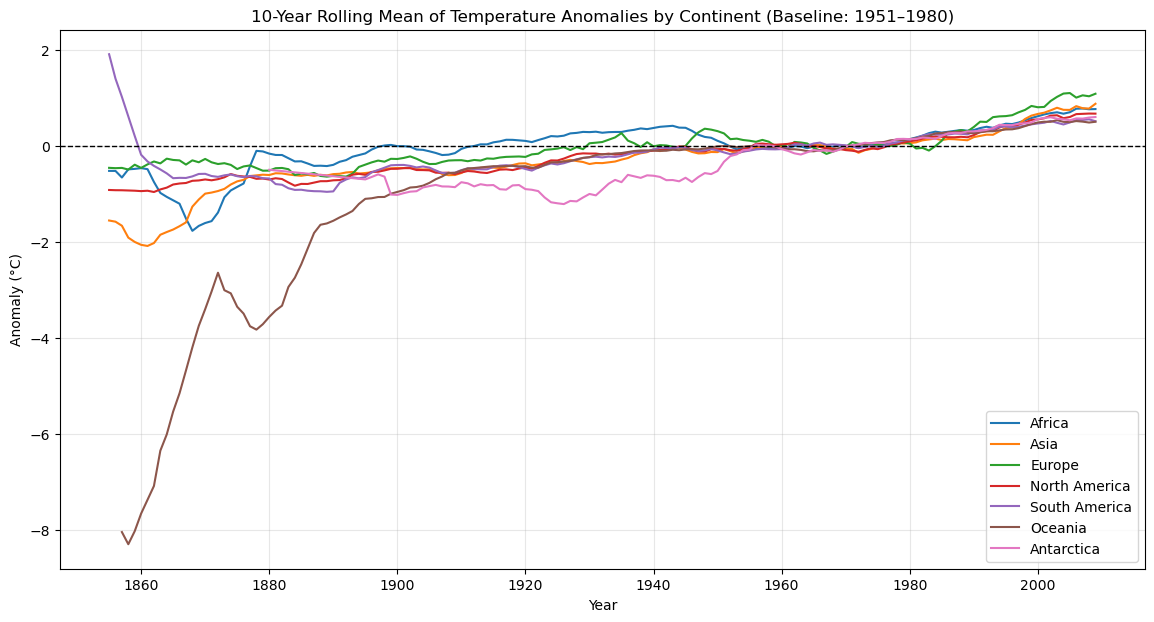

In [28]:
# Apply 10-year rolling mean for smoothing
annual_anomalies["RollingAnomaly"] = (
    annual_anomalies.groupby("Continent")["Anomaly"]
    .transform(lambda x: x.rolling(10, center=True).mean())
)

# Plot smoothed anomalies
plt.figure(figsize=(14,7))

for cont in annual_anomalies["Continent"].unique():
    subset = annual_anomalies[annual_anomalies["Continent"] == cont]
    plt.plot(subset["Year"], subset["RollingAnomaly"], label=cont)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("10-Year Rolling Mean of Temperature Anomalies by Continent (Baseline: 1951–1980)")
plt.xlabel("Year")
plt.ylabel("Anomaly (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Observations from Smoothed Anomalies

- **Early record (pre-1900):** Data is messy, with some sharp swings (especially in Oceania and South America) that likely reflect sparse or inconsistent measurements.  
- **Around mid-20th century (1950 baseline period):** Most continents hover close to zero, as expected, since anomalies are calculated relative to this period.  
- **Post-1950 trend:** Every continent shows a clear upward climb above the baseline. Europe and Asia in particular rise steadily after ~1970, while Africa and South America follow similar upward paths.  
- **Antarctica:** Shows variability but also trends upward in recent decades.  
- **Global pattern:** Despite regional differences, all continents are moving into positive anomaly territory in the late 20th and early 21st century, reinforcing the signal of broad global warming.  

These smoothed anomalies highlight both the differences in timing across continents and the shared global trend of rising temperatures relative to the mid-20th century baseline.


---

### Quantifying Warming Rates by Continent

The anomaly plots clearly show that all continents have warmed since the mid-20th century, but the pace of that warming may differ by region.  
To measure this more precisely, I’ll fit a simple linear regression of anomaly against year for each continent.  
The slope of the regression line gives the average warming rate in °C per year, which I’ll scale to °C per century for easier interpretation.


In [32]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

warming_rates = []

for cont in annual_anomalies["Continent"].unique():
    sub = (
        annual_anomalies.loc[annual_anomalies["Continent"] == cont]
        .dropna(subset=["Anomaly", "Year"])
        .copy()
    )
    if sub.empty:
        continue

    X = sub["Year"].to_numpy().reshape(-1, 1)
    y = sub["Anomaly"].to_numpy()

    model = LinearRegression().fit(X, y)
    slope_century = model.coef_[0] * 100  # °C per century
    warming_rates.append({"Continent": cont, "WarmingRate_C_per_Century": slope_century})

warming_df = pd.DataFrame(warming_rates).sort_values("WarmingRate_C_per_Century", ascending=False)
display(warming_df)

from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

warming_rates_post1900 = []

for cont in annual_anomalies["Continent"].unique():
    sub = (
        annual_anomalies.loc[
            (annual_anomalies["Continent"] == cont) & (annual_anomalies["Year"] >= 1900)
        ]
        .dropna(subset=["Anomaly", "Year"])
        .copy()
    )
    if sub.empty:
        continue

    X = sub["Year"].to_numpy().reshape(-1, 1)
    y = sub["Anomaly"].to_numpy()

    model = LinearRegression().fit(X, y)
    slope_century = model.coef_[0] * 100  # °C per century
    warming_rates_post1900.append({"Continent": cont, "WarmingRate_C_per_Century": slope_century})

warming_df_post1900 = pd.DataFrame(warming_rates_post1900).sort_values(
    "WarmingRate_C_per_Century", ascending=False
)

display(warming_df_post1900)

,Continent,WarmingRate_C_per_Century
5,Oceania,3.868644
1,Asia,1.280735
6,Antarctica,1.275529
3,North America,0.941158
0,Africa,0.854228
2,Europe,0.826792
4,South America,0.293689


,Continent,WarmingRate_C_per_Century
6,Antarctica,1.672098
1,Asia,1.144230
2,Europe,1.062445
5,Oceania,1.059946
3,North America,1.038380
4,South America,0.942158
0,Africa,0.512247


### Comparing Warming Rates: Full Period vs Post-1900

I first calculated warming rates using the full dataset (1850–2013). While this gave a broad view, some of the results looked unusual — especially **Oceania (≈ 3.9 °C per century)** and **South America (≈ 0.3 °C per century)**. Both regions showed strange early spikes and drops in the 1800s that pulled their regression slopes to extremes.

To check whether this early noise was skewing the results, I recalculated warming rates using only **post-1900 data**, when records are more consistent. The results are much more balanced across continents:

- **Antarctica (≈ 1.7 °C per century):** The strongest warming rate in the modern record.  
- **Asia (≈ 1.1 °C per century) and Europe (≈ 1.1 °C per century):** Clear, steady warming.  
- **Oceania (≈ 1.1 °C per century) and North America (≈ 1.0 °C per century):** Now much closer to the global average rate, no longer extreme outliers.  
- **South America (≈ 0.9 °C per century):** Shows meaningful warming once early outliers are removed.  
- **Africa (≈ 0.5 °C per century):** The lowest warming rate, but still positive.

These results suggest that the **post-1900 analysis provides a more realistic picture** of regional warming. Early 1800s records, while valuable historically, introduce volatility that can distort trends. Focusing on the modern period gives a clearer and more consistent understanding of how different regions are experiencing climate change.


---

In [35]:
# Save post-1850 dataset
df_post1850.to_csv("GlobalTemp_Post1850.csv", index=False)
print("Saved:", "GlobalTemp_Post1850.csv", "| Rows:", df_post1850.shape[0])

# Save annual anomalies dataset
annual_anomalies.to_csv("Annual_Anomalies.csv", index=False)
print("Saved:", "Annual_Anomalies.csv", "| Rows:", annual_anomalies.shape[0])

Saved: GlobalTemp_Post1850.csv | Rows: 432933
Saved: Annual_Anomalies.csv | Rows: 1107


## Transition to Modeling Analysis

The exploratory data analysis (EDA) phase helped identify key trends, data quality issues, and regional warming patterns.  
At this point, the dataset has been cleaned, baseline anomalies have been calculated, and both global and continental warming rates have been quantified.  

With this foundation in place, the next step is to move into a dedicated **Modeling Analysis notebook**.  
There, I’ll begin testing models, training and validating data, and exploring approaches for forecasting and further hypothesis testing.  

The following CSVs have been saved to support this transition:  
- `GlobalTemp_Cleaned_CountryContinent.csv` (full cleaned dataset)  
- `GlobalTemp_Post1850.csv` (trimmed dataset for more reliable records)  
- `Annual_Anomalies.csv` (baseline-adjusted anomalies for regression/forecasting)  

This ensures the modeling stage can pick up seamlessly without repeating the data wrangling and EDA steps.


In [50]:
import os
import matplotlib.pyplot as plt

# Global folder for plots
plot_path = "handoff_outputs/plots"
os.makedirs(plot_path, exist_ok=True)

# Save helper
def save_plot(filename):
    filepath = os.path.join(plot_path, filename)
    plt.savefig(filepath, bbox_inches="tight")
    plt.close()
    print(f"Saved: {filepath}")

In [60]:
# Apply 10-year rolling mean for smoothing
annual_anomalies["RollingAnomaly"] = (
    annual_anomalies.groupby("Continent")["Anomaly"]
    .transform(lambda x: x.rolling(10, center=True).mean())
)

# Plot smoothed anomalies
plt.figure(figsize=(14,7))

for cont in annual_anomalies["Continent"].unique():
    subset = annual_anomalies[annual_anomalies["Continent"] == cont]
    plt.plot(subset["Year"], subset["RollingAnomaly"], label=cont)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("10-Year Rolling Mean of Temperature Anomalies by Continent (Baseline: 1951–1980)")
plt.xlabel("Year")
plt.ylabel("Anomaly (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
save_plot("continent_temperature_anomalies.png")

Saved: handoff_outputs/plots\continent_temperature_anomalies.png
